In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from osgeo import gdal
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd

from torchinfo import summary
import gc
from torch.autograd import Variable

In [2]:
from tqdm.auto import tqdm # progress bar
from timeit import default_timer as timer
def print_train_time(start:float,
                    end:float,
                    device: torch.device= None):
    total_time=end-start
    print(f"Train time on {device} : {total_time:.3f} seconds")
    return total_time



In [3]:
# Grab the paths to all of the images in the 20m buffer folder
inputPath1="../data/processed/cam-2016-25m" # 16011 files
inputPath2="../data/processed/cam-2020-25m" # 16011 files
inputPath3="../data/processed/glo-2018-25m" # 16011 files
inputPath4="../data/processed/glo-2021-25m" # 16011 files
inputPath5="../data/processed/oxf-2016-25m" # 16011 files
inputPath6="../data/processed/oxf-2019-25m" # 16011 files
folderpaths = [inputPath1,inputPath2,inputPath3,inputPath4,inputPath5,inputPath6]
filelist = []

# Load the images, and append them to a list.
for folder in folderpaths: 
    for filepath in os.listdir(folder):
        if filepath.endswith((".tif")):
            #print(filepath)
            tempfile=folder+'/{0}'.format(filepath)
            filelist.append(tempfile)

In [4]:
len(filelist) # 107305 files

107305

In [9]:
# Grab the paths to all of the images in the 20m buffer folder
inputPath1="../data/processed/cam-2016-100m" # 16011 files
inputPath2="../data/processed/cam-2020-100m" # 16011 files
inputPath3="../data/processed/glo-2018-100m" # 16011 files
inputPath4="../data/processed/glo-2021-100m" # 16011 files
inputPath5="../data/processed/oxf-2016-100m" # 16011 files
inputPath6="../data/processed/oxf-2019-100m" # 16011 files
folderpaths = [inputPath1,inputPath2,inputPath3,inputPath4,inputPath5,inputPath6]
filelist_100m = []

# Load the images, and append them to a list.
for folder in folderpaths: 
    for filepath in os.listdir(folder):
        if filepath.endswith((".tif")):
            #print(filepath)
            tempfile=folder+'/{0}'.format(filepath)
            filelist_100m.append(tempfile)

In [12]:
len(filelist_100m) # 105441 files

105441

In [8]:
filelist[7]

'../data/processed/cam-2016-25m/cambdrige-25m-point-10005.tif'

In [13]:
# Create a list with all of the images as arrays -
images = []

# Generate data
for i, ID in enumerate(filelist):
    # Store sample
    dataset = gdal.Open(ID)
    image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
    images.append(image)  # Append the NumPy array to the list.
    if i>2000:
        break

In [19]:
images[0].shape
images = images[:1500]

In [20]:
# Make images into on big array and then transpose for use in ML model
all_data= np.stack(images, axis= 0)
#all_data = np.transpose(all_data, axes=[0, 2, 3, 1])
# normalize values of the input data to 0,1
all_data = all_data/255
all_data.shape

(1500, 3, 200, 200)

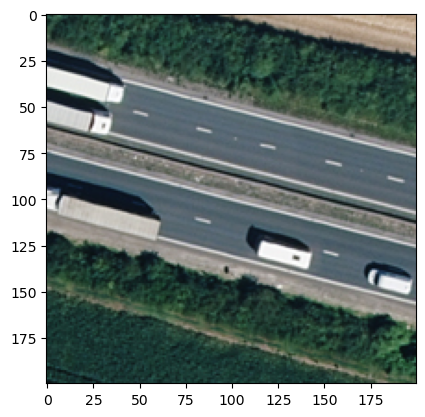

In [21]:
plt.imshow(np.transpose(all_data, axes=[0, 2, 3, 1])[0])

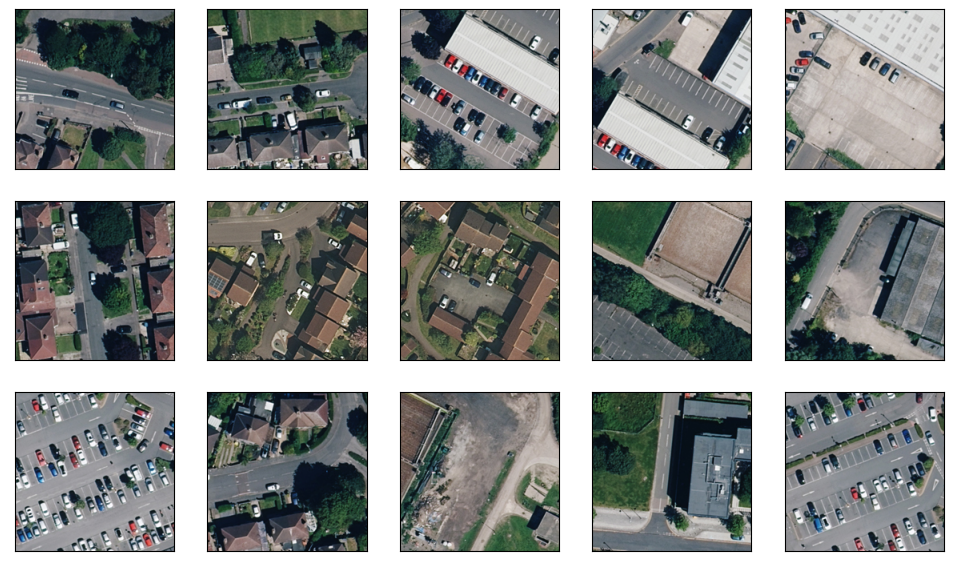

In [22]:
# function to display images
def display(array1, array2, array3):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    indices = np.random.choice(len(array1), size=n, replace=False)
    images2 = array2[indices]
    indices = np.random.choice(len(array1), size=n, replace=False)
    images3 = array3[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(5, n, i + 1)
        plt.imshow(np.transpose(image1, axes=[1, 2, 0]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.imshow(np.transpose(image2, axes=[1, 2, 0]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(5, n, i + 1 + n + n)
        plt.imshow(np.transpose(image3, axes=[1, 2, 0]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

display(all_data,all_data,all_data)

In [48]:
# # lets take like 500 images, split into train/test and then see what a basic autoencoder can do
# device = "cuda" if torch.cuda.is_available() else "cpu"
# data_subset =all_data[:500]
# data_subset= torch.tensor(data_subset).to(device)
# data_subset.shape

torch.Size([2000, 3, 160, 160])

In [49]:
# # split up the data into train/val
# np.random.seed(14)
# mask = torch.rand(len(data_subset)) <=.7

# training_data = torch.clone(data_subset)[mask]
# val_data = torch.clone(data_subset)[~mask]

# # # create train/test splits
# # from sklearn.model_selection import train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(data_subset,data_subset,test_size=.3,random_state=42)

In [50]:
# training_data.shape , val_data.shape

(torch.Size([1405, 3, 160, 160]), torch.Size([595, 3, 160, 160]))

In [100]:
gc.collect()

1710

In [5]:
from sklearn.model_selection import train_test_split

filelist_train ,filelist_test = train_test_split(filelist,test_size=0.25,random_state=42) 

In [6]:
len(filelist_train), len(filelist_test)

(80478, 26827)

In [17]:
from torch.utils.data import Dataset, DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
# Create a DataLOader for my data
class rgb25mdataset_train(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,filelist_train, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.filelist = filelist_train           

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        # Generate data
        dataset = gdal.Open(self.filelist[idx])
        image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
        image = image/255

        return image
    
class rgb25mdataset_test(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,filelist_test, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.filelist = filelist_test           

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        # Generate data
        dataset = gdal.Open(self.filelist[idx])
        image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
        image = image/255

        return image
    
my_dataset_train = rgb25mdataset_train(filelist_train=filelist_train)
my_dataset_test = rgb25mdataset_test(filelist_test=filelist_test)

my_dataloader_train = DataLoader(my_dataset_train, batch_size=20,shuffle=True, num_workers=0)
my_dataloader_test = DataLoader(my_dataset_test, batch_size=20,shuffle=False, num_workers=0)

In [70]:
# len(my_dataset_train),len(my_dataset_test)

(72049, 24017)

In [71]:
# sample = my_dataset_train[1]
# sample.shape

(3, 200, 200)

In [73]:
# # make sure the batching works
# for i_batch, sample_batched in enumerate(my_dataloader_train):
#     print(i_batch, sample_batched.shape)

#     # observe 4th batch and stop.
#     if i_batch == 3:
#         break

0 torch.Size([20, 3, 200, 200])
1 torch.Size([20, 3, 200, 200])
2 torch.Size([20, 3, 200, 200])
3 torch.Size([20, 3, 200, 200])


In [ ]:
# To use a Basic AE it only really makes sense if the image is in greyscale (one band) 
# So convert RGB tensors to a vector of greyscale tensors to see what comes out

# Not sure if you can just use R,G, or B or if we need to do some conversion formula

In [74]:
# class BasicAE(nn.Module): #nn.Module is base class for all nn modules
#     def __init__(self):
#         super().__init__()
        
#         self.flatten= nn.Flatten()
#         self.encoder_1 = nn.Linear(in_features=76800,
#                                 out_features=2048)
#         self.encoder_2 = nn.Linear(in_features=2048,
#                                 out_features=512)
#         self.encoder_3 = nn.Linear(in_features=512,
#                                 out_features=256)
#         self.encoder_4 = nn.Linear(in_features=256,
#                                 out_features=64)
        
        
        
#         self.decoder_1 = nn.Linear(in_features=64,
#                                 out_features=256)
#         self.decoder_2 = nn.Linear(in_features=256,
#                                 out_features=512)
#         self.decoder_3 = nn.Linear(in_features=512,
#                                 out_features=2048)
#         self.decoder_4 = nn.Linear(in_features=2048,
#                                 out_features=76800)
#         self.out_features = nn.Unflatten(1,torch.Size([3, 160, 160]))
        
        
        
#     def forward(self,x):
#         x = F.relu(self.encoder_1(self.flatten(x)))
#         x = F.relu(self.encoder_2(x))
#         x = F.relu(self.encoder_3(x))
#         x = F.relu(self.encoder_4(x))
#         x = F.relu(self.decoder_1(x))                                    
#         x = F.relu(self.decoder_2(x))
#         x = F.relu(self.decoder_3(x)) 
#         x = F.relu(self.decoder_4(x))
#         x = self.out_features(x)
#         return x
    
# torch.manual_seed(42)
# bae_1 = BasicAE()#.to(device)
# bae_1

In [75]:
# # Loss Function
# loss_fn = nn.MSELoss() # sigmoid activation function built in

# # Opitimiser
# optimizer = optim.Adam(params=bae_1.parameters(),
#                      lr=.01) # learning rate

# # calculate accuracy (for what percent of pixels is our model correct?)
# def mae_fn(y_true,y_pred):
#     mae = torch.abs((y_true-y_pred)).sum()
#     return mae



# # Build the training Loop (and a testing loop)

# # Loop through the data
# # forward pass (data moving thorugh models forward fucntions)
# # Calculate loss (compare forwrard pass predictions to labels)
# # Optimizer zero gradient
# # Loss backward - move backwards to calculate the gradients of each parameter with respect to the loss
# # Optimizer step - update weights to try and improve the loss (graident descent)
# torch.manual_seed(42)
# epochs = 5
# # # track various values
# # epoch_count= []
# # loss_values= []
# # test_loss_values= []
# # test_accuracy= []
# # train_accuracy= []

# # put data on target device (device agnostic code)
# training_data=training_data.to("cpu")
# val_data=val_data.to("cpu")


# batch_size= 25

# train_time_start_on_cpu = timer()
# # Training Loop
# for epoch in range(epochs):
#     print(f"Epoch {epoch + 1} out of {epochs}")
#     train_loss = 0
    
#     # Loop through training batch data
#     for i in range(0, len(training_data), batch_size):
#         X = training_data[i:i+batch_size]
#         bae_1.train()
#         # Forward Pass
#         y_pred = bae_1(X)
        
#         # Calc loss (per batch)
#         loss = loss_fn(y_pred, X)  # loss tested against itself
#         train_loss += loss # accumulate train loss
        
#         # Optimizer zero grad
#         optimizer.zero_grad()
        
#         # perform backpropagation on the loss
#         loss.backward()
        
#         # performm gradient descent
#         optimizer.step()
        
#         if i % 100 == 0:
#             print(f"Batch {i/25} out of {len(training_data)/batch_size} completed.")
            
#     # Divide total train loss by length of dataloader
#     train_loss /= (len(training_data)/batch_size)
        
#     ### Testing
#     test_loss, test_mae = 0,0
    
#     bae_1.eval()
#     with torch.inference_mode():
#         for i in range(0, len(val_data), batch_size):
#             X = val_data[i:i+batch_size]
#             # Forward pass
#             test_pred = bae_1(X)
            
#             # loss accumulate
#             test_loss += loss_fn(test_pred,X)
            
#             #Accuracy accumulate
#             test_mae += mae_fn(y_true=X, y_pred=test_pred)
        
#         # get loss per batch
#         test_loss /= (len(val_data)/batch_size)
        
#         # get acc per batch
#         test_mae /= (len(val_data)/batch_size)
        
#     print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_mae:.2f}")


# train_time_end_on_cpu = timer()    
# total_train_time_on_cpu= print_train_time(start=train_time_start_on_cpu,
#                                           end=train_time_end_on_cpu,
#                                           device=str(next(bae_1.parameters()).device))

In [76]:
# bae_1.eval()
# with torch.inference_mode():
#     test_pred = bae_1(val_data[122:123])

In [77]:
# ax = plt.subplot(1,2,1)
# plt.imshow(np.transpose(test_pred, axes=[0, 2, 3, 1])[0])

# ax = plt.subplot(1,2,2)
# plt.imshow(np.transpose(val_data[122:123], axes=[0, 2, 3, 1])[0])



100.0

# Now try a CAE

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(64),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(128),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64,32,kernel_size=3,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(2, stride=2),
#             nn.Conv2d(32,32,kernel_size=3,padding=1),
#             nn.LeakyReLU(True),
            )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(64),

            nn.Upsample(scale_factor=2, mode='nearest'), #align_corners=True),

            #nn.ReflectionPad2d(1),
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(128),
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128,64,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,32,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(32,3,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.Sigmoid())
    def forward(self,x):
        x = self.encoder(x)
        #x = x.view(-1,256,7,7)
        x = self.decoder(x)
        return x    
torch.manual_seed(42)
#cae_1 = CAE()#.to(device)
cae_1 = Autoencoder().to(device)
cae_1, summary(cae_1,input_size= (1,3,200,200))

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): LeakyReLU(negative_slope=True)
     (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): LeakyReLU(negative_slope=True)
     (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): LeakyReLU(negative_slope=True)
     (9): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (12): LeakyReLU(negative_slope=True)
     (13): InstanceNorm2d(64, ep

In [40]:
#help(nn.Upsample())
len(my_dataloader_train)

3220

In [17]:
gc.collect()

199

In [19]:
# make sure the shape is what we want
next(iter(my_dataloader_train))[1].shape

torch.Size([3, 200, 200])

In [41]:
# Can run a Train/Test Loop now
# Loss Function
loss_fn = nn.MSELoss() # sigmoid activation function built in

# Opitimiser
optimizer = optim.Adam(params=cae_1.parameters(),
                     lr=.001,
                      weight_decay=1e-5)

# calculate accuracy (for what percent of pixels is our model correct?)
def mae_fn(y_true,y_pred):
    mae = torch.abs((y_true-y_pred)).sum()
    return mae



# Build the training Loop (and a testing loop)

# Loop through the data
# forward pass (data moving thorugh models forward fucntions)
# Calculate loss (compare forwrard pass predictions to labels)
# Optimizer zero gradient
# Loss backward - move backwards to calculate the gradients of each parameter with respect to the loss
# Optimizer step - update weights to try and improve the loss (graident descent)
torch.manual_seed(42)
epochs = 5
# # track various values
# epoch_count= []
# loss_values= []
# test_loss_values= []
# test_accuracy= []
# train_accuracy= []

# put data on target device (device agnostic code)
# training_data=training_data.to(device)
# val_data=val_data.to(device)

# Instatiate datasets/loaders
my_dataset_train = rgb25mdataset_train(filelist_train=filelist_train)
my_dataset_test = rgb25mdataset_test(filelist_test=filelist_test)

my_dataloader_train = DataLoader(my_dataset_train, batch_size=25,shuffle=True, num_workers=0)
my_dataloader_test = DataLoader(my_dataset_test, batch_size=25,shuffle=False, num_workers=0)

#batch_size= 5

train_time_start_on_cpu = timer()
# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} out of {epochs}")
    train_loss = 0
    
    # Loop through training batch data
    for i_batch, sample_batched in enumerate(my_dataloader_train):
        X = sample_batched.to(device)
        X = Variable(X.float().cuda())
        cae_1.train()
        # Forward Pass
        y_pred = cae_1(X)
        
        # Calc loss (per batch)
        loss = loss_fn(y_pred, X)  # loss tested against itself
        train_loss += loss # accumulate train loss
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # perform backpropagation on the loss
        loss.backward()
        
        # performm gradient descent
        optimizer.step()
        
        if i_batch % 200 == 0:
            print(f"Batch {i_batch+1} out of {len(my_dataloader_train)} completed.")
            
    # Divide total train loss by length of dataloader
    train_loss /= (len(my_dataset_train)/batch_size)
        
    ### Testing
    test_loss, test_mae = 0,0
    
    cae_1.eval()
    with torch.inference_mode():
         for i_batch, sample_batched in enumerate(my_dataloader_test):
            X = sample_batched.to(device)
            X = Variable(X.float().cuda())
            # Forward pass
            test_pred = cae_1(X)
            
            # loss accumulate
            test_loss += loss_fn(test_pred,X)
            
            #Accuracy accumulate
            test_mae += mae_fn(y_true=X, y_pred=test_pred)
         
         # get loss per batch
         test_loss /= (len(my_dataset_test)/batch_size)
         
         # get acc per batch
         test_mae /= (len(my_dataset_test)/batch_size)
        
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_mae:.2f}")


train_time_end_on_cpu = timer()    
total_train_time_on_cpu= print_train_time(start=train_time_start_on_cpu,
                                          end=train_time_end_on_cpu,
                                          device=str(next(cae_1.parameters()).device))

# 157783.14 MAE
# 1 epoch 40201.82 855.967 seconds
# 5 epochs 35617.16 5221.646 seconds 

Epoch 1 out of 5
Batch 1 out of 3220 completed.
Batch 201 out of 3220 completed.
Batch 401 out of 3220 completed.
Batch 601 out of 3220 completed.
Batch 801 out of 3220 completed.
Batch 1001 out of 3220 completed.
Batch 1201 out of 3220 completed.
Batch 1401 out of 3220 completed.
Batch 1601 out of 3220 completed.
Batch 1801 out of 3220 completed.
Batch 2001 out of 3220 completed.
Batch 2201 out of 3220 completed.
Batch 2401 out of 3220 completed.
Batch 2601 out of 3220 completed.
Batch 2801 out of 3220 completed.
Batch 3001 out of 3220 completed.
Batch 3201 out of 3220 completed.
Train Loss: 0.0019 | Test Loss: 0.0020 | Test Acc: 44307.39
Epoch 2 out of 5
Batch 1 out of 3220 completed.
Batch 201 out of 3220 completed.
Batch 401 out of 3220 completed.
Batch 601 out of 3220 completed.
Batch 801 out of 3220 completed.
Batch 1001 out of 3220 completed.
Batch 1201 out of 3220 completed.
Batch 1401 out of 3220 completed.
Batch 1601 out of 3220 completed.
Batch 1801 out of 3220 completed.
Ba

In [120]:
# m = nn.Upsample(size=[10,10], mode='nearest')
# b = nn.ReflectionPad2d(3)
# #b(m(torch.rand((10,5,5)))).shape,m(torch.rand((10,5,5))).shape 
# m(torch.rand((1,10,5,5))).shape 
# torch.save(cae_1.state_dict(),"../data/models/cae_25m.pt") # currently with 5 epochs
gc.collect()

3447

In [118]:
# my_dataset_train = rgb25mdataset_train(filelist_train=filelist_train)
# my_dataset_test = rgb25mdataset_test(filelist_test=filelist_test)

# my_dataloader_train = DataLoader(my_dataset_train, batch_size=25,shuffle=True, num_workers=0)
# my_dataloader_test = DataLoader(my_dataset_test, batch_size=25,shuffle=False, num_workers=0)

In [121]:
# see how well the images are predicted by the model
cae_1.eval()
with torch.inference_mode():
    X = next(iter(my_dataloader_test))
    X = X.to(device)
    X = Variable(X.float().cuda())
    test_pred = cae_1(X)

In [122]:
test_pred[0].shape

torch.Size([3, 200, 200])

In [123]:
len(X)

25

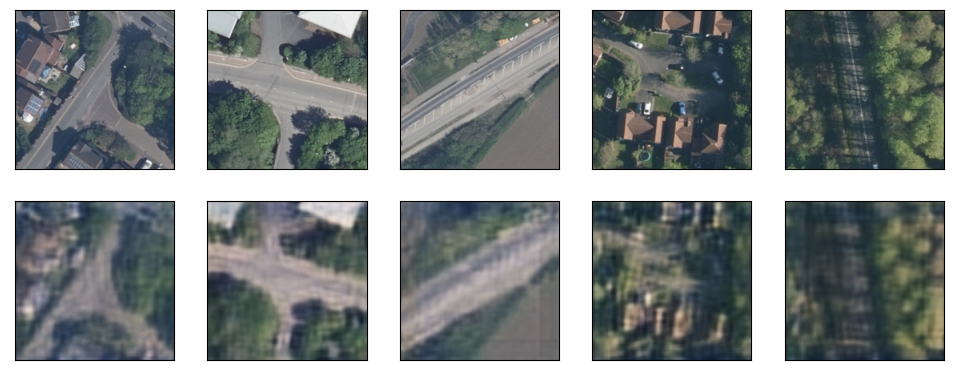

In [124]:
def display2(array1, array2):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    images2 = array2[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(5, n, i + 1)
        plt.imshow(np.transpose(image1.cpu(), axes=[1, 2, 0]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.imshow(np.transpose(image2.cpu(), axes=[1, 2, 0]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

    plt.show()
display2(X, test_pred)

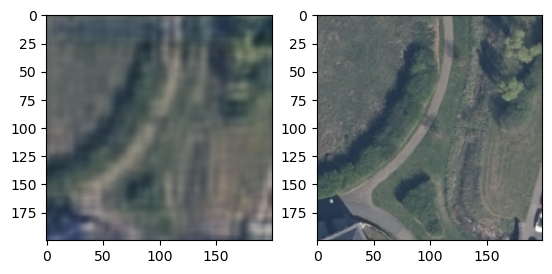

In [56]:
# ax = plt.subplot(1,2,1)
# plt.imshow(np.transpose(test_pred.cpu(), axes=[0, 2, 3, 1])[2])

# ax = plt.subplot(1,2,2)
# plt.imshow(np.transpose(X.cpu(), axes=[0, 2, 3, 1])[2])

In [116]:
cae_1.state_dict()

OrderedDict([('encoder.0.weight',
              tensor([[[[ 0.0553,  0.0875,  0.0575],
                        [ 0.0728,  0.0544,  0.0692],
                        [-0.0271,  0.0035, -0.0146]],
              
                       [[-0.0056,  0.0130, -0.0198],
                        [ 0.0495,  0.0019,  0.0204],
                        [ 0.0127,  0.0313, -0.0026]],
              
                       [[-0.0456, -0.0069, -0.0185],
                        [ 0.0189, -0.0236,  0.0346],
                        [ 0.0034,  0.0223,  0.0124]]],
              
              
                      [[[-0.0725, -0.0229, -0.1391],
                        [ 0.0389, -0.1807,  0.0359],
                        [ 0.0452,  0.0457,  0.1462]],
              
                       [[ 0.0439,  0.0900,  0.0318],
                        [-0.1195, -0.0245, -0.0842],
                        [ 0.0415,  0.1801,  0.1302]],
              
                       [[-0.0025,  0.0630,  0.0525],
                      

In [10]:
cae_1.load_state_dict(torch.load("../data/models/cae_25m.pt"))

<All keys matched successfully>

In [18]:
%%time
# using just the encoding layers, get the image features... for now just of the test set..
prediction_list=[]
cae_1.eval()
with torch.inference_mode():
    for i_batch, sample_batched in enumerate(my_dataloader_test):
        X = sample_batched.to(device)
        X = Variable(X.float().cuda())
        test_pred = cae_1.encoder(X)
        prediction_list.append(test_pred.cpu())

CPU times: total: 21min 11s
Wall time: 2min 45s


In [19]:
len(prediction_list)

1342

In [20]:
prediction_list[0].shape

torch.Size([20, 32, 12, 12])

In [21]:
# stack the items in the list and then flatten to get one row of features per image
arr = np.vstack(prediction_list)
arr = arr.reshape(-1,4608)
arr.shape

(26827, 4608)

In [22]:
# convert to df
df = pd.DataFrame(arr)
df["file_path"] = filelist_test
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,file_path
0,0.066820,-0.646343,-0.012813,-0.291650,-0.501947,-0.871483,0.332327,-0.404748,-0.596287,-0.494417,...,0.584715,0.505150,0.754489,0.750900,0.009431,0.133339,0.496358,0.212997,0.011814,../data/processed/cam-2016-25m/cambdrige-25m-p...
1,-1.748947,-0.822722,-0.525193,-0.201431,-0.246531,-1.170550,-1.263862,-0.351626,0.010943,-1.216667,...,0.957895,0.935607,0.870999,1.069563,-0.491675,-0.362456,-0.197953,-0.468028,-1.330559,../data/processed/glo-2021-25m/gloucester-25m-...
2,-0.974752,-0.207831,-0.701708,-0.395834,-0.448195,-0.680279,-0.676957,-0.270040,-1.176902,0.372147,...,1.267254,0.746135,0.830255,0.226385,-0.140410,-0.040638,0.531682,0.360136,-0.433765,../data/processed/glo-2021-25m/gloucester-25m-...
3,-1.028587,-0.665060,-0.564062,-0.851081,-0.398494,-0.928020,-1.342871,-1.178661,-1.032883,-0.942380,...,-0.532454,0.406204,0.059265,-0.532149,-0.423228,0.321084,-0.488578,0.151527,0.767455,../data/processed/glo-2021-25m/gloucester-25m-...
4,-1.599855,0.243974,-0.951751,0.609137,-0.789370,-0.889489,-0.336313,-0.858258,-0.613412,-0.761079,...,0.885979,0.999796,0.630372,0.463618,0.431810,0.328018,0.293223,0.961664,1.132532,../data/processed/glo-2018-25m/gloucester-25m-...


In [23]:
# save a df of the image features
df.to_csv("../data/processed/image-features/cae-25m-features-21-11-22.csv")

# Now i need to do the same thing with the 100m images

In [75]:
len(filelist_100m)

105441

In [104]:
filelist_train_100m ,filelist_test_100m = train_test_split(filelist_100m[:25000],test_size=0.25) 
len(filelist_train_100m),len(filelist_test_100m)

(18750, 6250)

In [105]:
# Create a DataLOader for my data
class rgb25mdataset_train(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,filelist_train_100m, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.filelist = filelist_train_100m           

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        # Generate data
        dataset = gdal.Open(self.filelist[idx])
        image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
        image = image/255

        return image
    
class rgb25mdataset_test(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,filelist_test_100m, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.filelist = filelist_test_100m           

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        # Generate data
        dataset = gdal.Open(self.filelist[idx])
        image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
        image = image/255

        return image
    
my_dataset_train = rgb25mdataset_train(filelist_train_100m=filelist_train_100m)
my_dataset_test = rgb25mdataset_test(filelist_test_100m=filelist_test_100m)

my_dataloader_train = DataLoader(my_dataset_train, batch_size=20,shuffle=True, num_workers=0)
my_dataloader_test = DataLoader(my_dataset_test, batch_size=20,shuffle=True, num_workers=0)

In [80]:
len(my_dataloader_train),len(my_dataloader_test)

(3954, 1319)

In [106]:
class Autoencoder_100m(nn.Module):
    def __init__(self):
        super(Autoencoder_100m,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(64),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(128),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(128),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5         
            nn.Conv2d(128,64,kernel_size=3,padding=1),          
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64,64,kernel_size=3,padding=1),          
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64,32,kernel_size=3,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32,32,kernel_size=3,padding=1),
            nn.LeakyReLU(True),
            )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'), #align_corners=True),
            
            #nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'), #align_corners=True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(128),
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(128),
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128,64,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.LeakyReLU(True),
            nn.InstanceNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'),# align_corners=True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64,3,kernel_size=3,stride=1,padding=0),#,output_padding=1),
            nn.Sigmoid())
    def forward(self,x):
        x = self.encoder(x)
        #x = x.view(-1,256,7,7)
        x = self.decoder(x)
        return x    
torch.manual_seed(42)
#cae_1 = CAE()#.to(device)
cae_100 = Autoencoder_100m().to(device)
cae_100, summary(cae_100,input_size= (1,3,800,800))

(Autoencoder_100m(
   (encoder): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): LeakyReLU(negative_slope=True)
     (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): LeakyReLU(negative_slope=True)
     (6): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): LeakyReLU(negative_slope=True)
     (10): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (12): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 

In [114]:
# Can run a Train/Test Loop now
# Loss Function
loss_fn = nn.MSELoss() # sigmoid activation function built in

# Opitimiser
optimizer = optim.Adam(params=cae_1.parameters(),
                     lr=.001,
                      weight_decay=1e-5)

# calculate accuracy (for what percent of pixels is our model correct?)
def mae_fn(y_true,y_pred):
    mae = torch.abs((y_true-y_pred)).sum()
    return mae



# Build the training Loop (and a testing loop)

# Loop through the data
# forward pass (data moving thorugh models forward fucntions)
# Calculate loss (compare forwrard pass predictions to labels)
# Optimizer zero gradient
# Loss backward - move backwards to calculate the gradients of each parameter with respect to the loss
# Optimizer step - update weights to try and improve the loss (graident descent)
torch.manual_seed(42)
epochs = 1
# # track various values
# epoch_count= []
# loss_values= []
# test_loss_values= []
# test_accuracy= []
# train_accuracy= []

# put data on target device (device agnostic code)
# training_data=training_data.to(device)
# val_data=val_data.to(device)

# Instatiate datasets/loaders
my_dataset_train = rgb25mdataset_train(filelist_train_100m=filelist_train_100m)
my_dataset_test = rgb25mdataset_test(filelist_test_100m=filelist_test_100m)

my_dataloader_train = DataLoader(my_dataset_train, batch_size=10,shuffle=True, num_workers=0)
my_dataloader_test = DataLoader(my_dataset_test, batch_size=10,shuffle=True, num_workers=0)

#batch_size= 5

train_time_start_on_cpu = timer()
# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} out of {epochs}")
    train_loss = 0
    
    # Loop through training batch data
    for i_batch, sample_batched in enumerate(my_dataloader_train):
        X = sample_batched.to(device)
        X = Variable(X.float().cuda())
        cae_1.train()
        # Forward Pass
        y_pred = cae_1(X)
        
        # Calc loss (per batch)
        loss = loss_fn(y_pred, X)  # loss tested against itself
        train_loss += loss # accumulate train loss
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # perform backpropagation on the loss
        loss.backward()
        
        # performm gradient descent
        optimizer.step()
        
        if i_batch % 200 == 0:
            print(f"Batch {i_batch+1} out of {len(my_dataloader_train)} completed.")
            
    # Divide total train loss by length of dataloader
    train_loss /= (len(my_dataset_train)/batch_size)
        
    ### Testing
    test_loss, test_mae = 0,0
    
    cae_1.eval()
    with torch.inference_mode():
         for i_batch, sample_batched in enumerate(my_dataloader_test):
            X = sample_batched.to(device)
            X = Variable(X.float().cuda())
            # Forward pass
            test_pred = cae_1(X)
            
            # loss accumulate
            test_loss += loss_fn(test_pred,X)
            
            #Accuracy accumulate
            test_mae += mae_fn(y_true=X, y_pred=test_pred)
         
         # get loss per batch
         test_loss /= (len(my_dataset_test)/batch_size)
         
         # get acc per batch
         test_mae /= (len(my_dataset_test)/batch_size)
        
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_mae:.2f}")


train_time_end_on_cpu = timer()    
total_train_time_on_cpu= print_train_time(start=train_time_start_on_cpu,
                                          end=train_time_end_on_cpu,
                                          device=str(next(cae_1.parameters()).device))

# This model does not fit into my laptop memory

Epoch 1 out of 1


OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB (GPU 0; 4.00 GiB total capacity; 3.21 GiB already allocated; 0 bytes free; 3.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [113]:
gc.collect()

1863